> ### Forward Propagation

In [ ]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict

# Plotting
import PIL
from PIL import ImageDraw, Image
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

#Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import torch
import torch.nn as nn
import torch.nn.functional as F


<img src="images/model.png" style="width:600px;height:200px;">

#### Convolution Layer  

<img src="images/Convolution_schematic.gif" style="width:300px;height:200px;">
$$ n_H \times n_W \times n_C = \lfloor \frac{n_{H_{prev}} + 2pad - f}{stride} +1 \rfloor \times \lfloor \frac{n_{W_{prev}} + 2pad - f}{stride} +1 \rfloor \times n_C $$

In [79]:
def conv_single_step(A_slice_prev, W, b):
    Z = np.sum(A_slice_prev*W) + float(b)
    return Z

In [2]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), #按(m,h,w,c)来pad
                   mode='constant', constant_values = (0,0))
    return X_pad

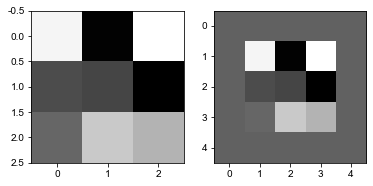

In [8]:
np.random.seed(1)
x = np.random.randn(4,3,3,3)
x_pad = zero_pad(x,1)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(x[0,:,:,0]) #单层channel为灰度图 plt.gray()
ax2.imshow(x_pad[0,:,:,0])

In [82]:
def conv_forward(A_prev, W, b, hparameters):
    # Input
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Output
    n_H = int((n_H_prev + 2*pad - f)/stride + 1)
    n_W = int((n_W_prev + 2*pad - f)/stride + 1)
    Z = np.zeros([m, n_H, n_W, n_C])
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                  
        for h in range(n_H):                
            for w in range(n_W):
                for c in range(n_C): 
                    # Vertical and horizontal start and end 
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_prev_slice, weights, biases)
                                        
    cache = (A_prev, W, b, hparameters)
    return Z, cache

#### Filters

In [40]:
# 数学复现
ver_filter = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]])

hor_filter = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]])

#维度可以在最前面加np.newaxis或者1,但是在最后面加会变形
ver = np.tile(ver_filter[np.newaxis,:,:],(3,1,1)) #把filter从fxf，copy变为3xfxf
hor = np.tile(hor_filter[np.newaxis,:,:],(3,1,1))
W = np.vstack([ver[np.newaxis,...],hor[np.newaxis,...]]) #把多个filter叠加为 nx3xfxf
W = np.transpose(W,[2,3,1,0]) #变为fxfx3xn
W.shape

(3, 3, 3, 2)

In [ ]:
image=image[np.newaxis,...]
b = np.zeros([1,1,1,2])
hparameters = {'stride':1,'pad':1}
Z, cache = conv_forward(image, W, b, hparameters)
Z.shape

Text(0.5, 1.0, 'Image')

Text(0.5, 1.0, 'Vertical line')

Text(0.5, 1.0, 'Horizontal line')

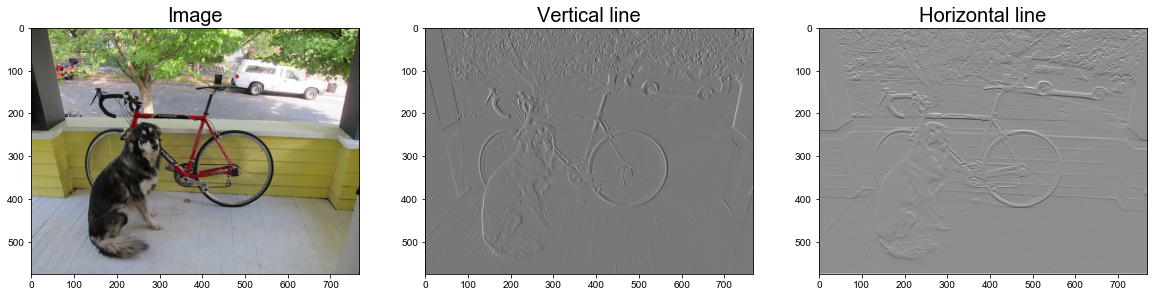

In [86]:
f,ax = plt.subplots(1,3,figsize=(10,8))
ax[0].imshow(image[0])
ax[0].set_title('Image',fontsize=20)
ax[1].imshow(Z[0,...,0])
ax[1].set_title('Vertical line',fontsize=20)
ax[2].imshow(Z[0,...,1])
ax[2].set_title('Horizontal line',fontsize=20)

#### Pooling Layer

In [ ]:
def pool_forward(A_prev, hparameters, mode = "max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int((n_H_prev - f)/stride + 1)
    n_W = int((n_W_prev - f)/stride + 1)
    n_C = n_C_prev
    A = np.zeros((m, n_H, n_W, n_C))              

    for i in range(m):                  
        for h in range(n_H):         
            for w in range(n_W):
                 for c in range (n_C): 
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    
                    a_prev_slice = A_prev[i,vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    return A, cache